# <center>Group-LASSO-problem 作业</center>

<center>李锦韬 2201213292</center>

本文档为 Group-LASSO-problem 作业的实验报告，用于进一步拓展说明ReadME中的内容。

## 问题描述

考虑以下问题：

$$
\min _{x \in \mathbb{R}^{n \times l}} \frac{1}{2}\|A x-b\|_F^2+\mu\|x\|_{1,2}
$$

其中 $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^{m \times l}$, $\mu>0$ 并且

$$
\|x\|_{1,2}=\sum_{i=1}^n\|x(i, 1: l)\|_2
$$

其中 $x(i, 1: l)$ 是矩阵 $x$ 的第 $i$ 行。

## 评价指标
本项目将使用以下指标来评价各个算法的性能：

- 算法得到的最终目标函数值 和 最优解对应的目标函数 之间的绝对值差 `Obj_ABS_Error`
- 算法得到的最终解 和 最优解 之间的 归一化 Frobenius 范数差 `x_u_Error`
- （对于非 mosek 和 gurobi 等自行编写的算法）对比其和此两者成熟求解器所得解之间的归一化 Frobenius 范数差 `x_CVXmosek_Error` 和 `x_CVXgurobi_Error`
- 算法求解的运行时间 `Time(s)`
- 算法求解的迭代次数 `Iter`
- 算法得到的最终解的稀疏度 `Sparsity`

下面具体地介绍各个指标的计算方法：

`Obj_ABS_Error` 的计算方法如下：
$$
Error_{f} = |f_{x} - f_{u}|
$$

其中 $f_{x}$ 为算法得到的最终目标函数值，$f_{u}$ 为最优解 $u$ 对应的目标函数值。

`x_u_Error` 的计算方法如下：
$$
Error(x, u) = \frac{\|x - u\|_F}{1 + \|u\|_F}
$$

其中 $x$ 为算法得到的最终解，$u$ 为最优解。

`x_CVXmosek_Error` 和 `x_CVXgurobi_Error` 的计算方法如下：
$$
Error(x, x_{cvx}) = \frac{\|x - x_{cvx}\|_F}{1 + \|x_{cvx}\|_F}
$$

其中 $x$ 为算法得到的最终解，$x_{cvx}$ 为使用 cvxpy + mosek 或 cvxpy + gurobi 求解得到的最优解。

`Sparsity` 的计算方法如下：

$$
Sparsity = \frac{\|x\|_0}{n \times l}
$$

其中 $x$ 为算法得到的最终解，$\|x\|_0$ 表示 $x$ 中非零元素的个数，在本项目中认为绝对值小于 $10^{-5}$ 的元素为零。


## CVX 求解

使用 CVX 软件包可以直接求解上述问题，无需变换问题形式。直接将 `X` 设为变量，并根据问题描述写出目标函数即可。

需要注意的是：本项目使用 CVX 的 python 版本，即 CVXPY，版本信息在README文件中。CVX 记录的迭代信息是通过 `verbose=True` 来实现的，由于其无法直接被读取和存储，本项目使用重定向 `stdout` 输出到文件的技巧记录迭代信息，之后采用正则表达式匹配的方式提取迭代信息。

代码的最后一步中的求解器可以分别选择 mosek 和 gurobi。
例如下面的形式：

In [ ]:
import numpy as np
import cvxpy as cp
def gl_cvx_mosek(x0: np.ndarray, A: np.ndarray, b: np.ndarray, mu: float, opts={}):
    X = cp.Variable(shape=(A.shape[1], b.shape[1]))
    X.value = x0
    objective = cp.Minimize(0.5 * cp.square(cp.norm(A @ X - b, 'fro')) + mu * cp.sum(cp.norm(X, 2, 1)))
    problem = cp.Problem(objective)
    problem.solve(solver=cp.MOSEK, verbose=True)

运行本项目编写的测试脚本，最终结果和迭代曲线如下所示。

可以注意到：

- CVX 可以自行转换相应的目标函数和约束条件，使其符合 mosek 和 gurobi 的要求；
- mosek 和 gurobi 的求解效率相差不大，但是 mosek 求解速度更快，单位迭代步所需时间也更少。
- mosek 和 gurobi 两者最终得到的解差别不大，从数值上几乎相同。
- gurobi 第一次迭代的目标函数值为负数值，可能是由于求解器初始求解时的特殊策略所致。


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Solver        Objective    Obj_ABS_Error    x_u_Error    Time(s)    Iter    Sparsity
----------  -----------  ---------------  -----------  ---------  ------  ----------
cvx_mosek      0.652291      1.36249e-05  3.91006e-05   0.483289      14    0.102539
cvx_gurobi     0.652291      1.32116e-05  3.96407e-05   1.94496       11    0.102539


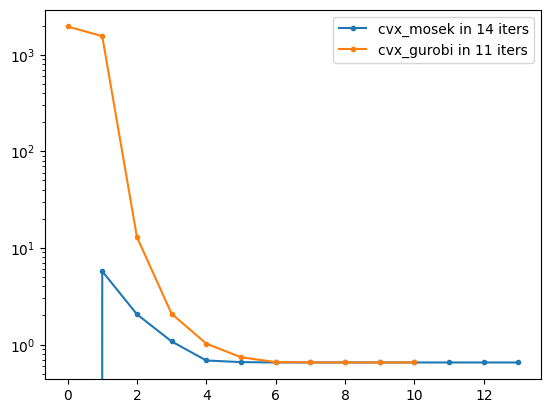

<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
%run Test_group_lasso.py -S gl_cvx_mosek gl_cvx_gurobi -P -L ERROR

## Mosek 和 gurobi 求解

Mosek 和 gurobi 同样拥有对应的 python 软件包，可以直接调用。但是由于其要求问题形式必须为标准形式，因此需要对原问题进行变换。

### Mosek

对于 Mosek，需要进行变量替换，令原问题中的前半部分2范数项为 $y$ 、 后半部分的组范数为 $z$ ，将难以处理的范数放入约束锥中，将原问题转换为如下形式：




$$

Minimize:
\begin{equation}
    \text{obj} = \frac{1}{2} t_1 + \mu \sum_{i=1}^{n} ts_i
\end{equation}
$$

$$

Subject to:
\begin{align}
    & AX - b = Y \\
    & \begin{bmatrix}
        1 + t_1 \\
        2Y_{\text{reshaped}} \\
        1 - t_1
    \end{bmatrix} \in \text{Second-Order Cone} \\
    & \begin{bmatrix}
        ts_i \\
        X_{\text{slice}(i)}^{\text{reshaped}}
    \end{bmatrix} \in \text{Second-Order Cone}, \quad \forall i = 1, \ldots, n
\end{align}

$$
